<a href="https://colab.research.google.com/github/Hasan-Bashir/MLforTerrainGeneration/blob/main/ProGAN_satellite_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Pytorch implementation of ProGAN adapted from:
# https://www.kaggle.com/code/tauilabdelilah/progan-implementation-from-scratch-pytorch/notebook
# A full explanation of the ProGAN code from the author can be found at:
# https://blog.paperspace.com/implementation-of-progan-from-scratch/

!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.1 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn, optim
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from math import log2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from datasets import load_dataset
from PIL import Image, UnidentifiedImageError
import io
import logging


logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything()

In [ ]:
DATASET                 = "HasanBashir/satellite-gan"
START_TRAIN_AT_IMG_SIZE = 4
DEVICE                  = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE           = 1e-3
BATCH_SIZES             = [32, 32, 32, 16, 16, 16] #you can use [32, 32, 32, 16, 16, 16, 16, 8, 4] for example if you want to train until 1024x1024, but again this numbers depend on your vram
image_size              = 128
CHANNELS_IMG            = 3
Z_DIM                   = 256  # should be 512 in original paper
IN_CHANNELS             = 256  # should be 512 in original paper
LAMBDA_GP               = 10
PROGRESSIVE_EPOCHS      = [30] * len(BATCH_SIZES)

In [ ]:
# This code is used to validate the satellite images in the hugging face dataset.
# If the dataset contains any satellite images that are invalid (corrupted/unreadable), we skip that image.


class SatelliteDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform
        self.valid_indices = []

        # Validate all images in the dataset first
        logger.info("Validating dataset images...")
        for i in tqdm(range(len(hf_dataset))):
            try:
                img_data = hf_dataset[i]['image']
                if isinstance(img_data, Image.Image):
                    # Already a PIL image
                    self.valid_indices.append(i)
                else:
                    # Try to open from bytes
                    Image.open(io.BytesIO(img_data)).verify()
                    self.valid_indices.append(i)
            except (UnidentifiedImageError, TypeError, ValueError, OSError) as e:
                logger.warning(f"Skipping invalid image at index {i}: {str(e)}")
                continue

        logger.info(f"Found {len(self.valid_indices)} valid images out of {len(hf_dataset)}")
    # Return the number of valid images in the dataset
    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        # Get the actual index from our valid image list
        actual_idx = self.valid_indices[idx]

        try:
            # Extract the image from the dataset
            img_data = self.dataset[actual_idx]['image']

            # Convert to RGB Image if it's not already
            if not isinstance(img_data, Image.Image):
                img = Image.open(io.BytesIO(img_data)).convert("RGB")
            else:
                img = img_data.convert("RGB")

            if self.transform:
                img = self.transform(img)

            # Return image with 0 as a dummy label (as we don't require labels for this task)
            return img, 0

        except (UnidentifiedImageError, TypeError, ValueError, OSError) as e:
            # In case images are still unreadable, return a placeholder image
            logger.error(f"Error processing image at valid index {idx} (actual {actual_idx}): {str(e)}")
            # Return a placeholder image (black)
            placeholder = torch.zeros((CHANNELS_IMG, image_size, image_size))
            if self.transform:
                # Apply the normalize part of the transform
                placeholder = transforms.Normalize(
                    [0.5 for _ in range(CHANNELS_IMG)],
                    [0.5 for _ in range(CHANNELS_IMG)]
                )(placeholder)
            return placeholder, 0

In [ ]:
# Resize images to the size we require and transorm/normalise the dataset

def get_loader(image_size):
    transform = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Normalize(
                [0.5 for _ in range(CHANNELS_IMG)],
                [0.5 for _ in range(CHANNELS_IMG)],
            ),
        ]
    )
    batch_size = BATCH_SIZES[int(log2(image_size / 4))]
    logger.info(f"Loading dataset {DATASET}...")
    hf_dataset = load_dataset(DATASET, split="train", streaming=False)
    dataset = SatelliteDataset(hf_dataset, transform=transform)
    if len(dataset) == 0:
        raise RuntimeError("No valid images found in the dataset!")
        # Create mini-batches
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
    )
    return loader, dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/289 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/357M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/19929 [00:00<?, ? examples/s]

100%|██████████| 19929/19929 [00:13<00:00, 1465.19it/s]


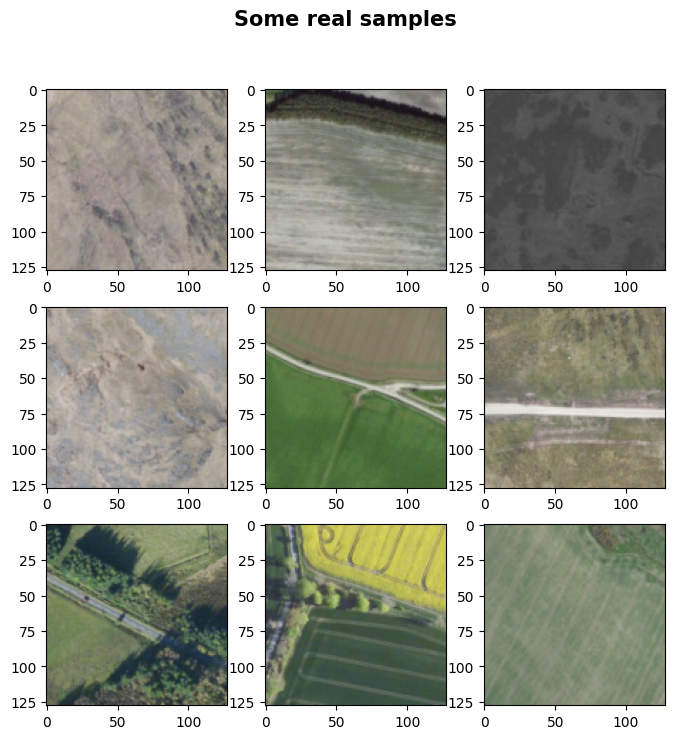

In [ ]:
# Check if everything works and produce some real training samples

def check_loader():
    loader,_ = get_loader(128)
    cloth ,_ = next(iter(loader))
    _, ax    = plt.subplots(3,3, figsize=(8,8))
    plt.suptitle('Some real samples', fontsize=15, fontweight='bold')
    ind = 0
    for k in range(3):
        for kk in range(3):
            ind += 1
            ax[k][kk].imshow((cloth[ind].permute(1,2,0)+1)/2)
check_loader()

In [ ]:
factors = [1, 1, 1, 1, 1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32]

In [ ]:
# Implementation of the equalised learning rate from ProGAN architecture.

class WSConv2d(nn.Module):

    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1,
    ):
        super(WSConv2d, self).__init__()
        self.conv      = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale     = (2 / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias      = self.conv.bias #Copy the bias of the current column layer
        self.conv.bias = None      #Remove the bias

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

In [ ]:
# Adding in pixelnorm normalisation

class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_pixelnorm=True):
        super(ConvBlock, self).__init__()
        self.use_pn = use_pixelnorm
        self.conv1  = WSConv2d(in_channels, out_channels)
        self.conv2  = WSConv2d(out_channels, out_channels)
        self.leaky  = nn.LeakyReLU(0.2)
        self.pn     = PixelNorm()

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.use_pn else x
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.use_pn else x
        return x

In [ ]:
# Create the generator

class Generator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Generator, self).__init__()

        # initial takes 1x1 -> 4x4
        self.initial = nn.Sequential(
            PixelNorm(),
            nn.ConvTranspose2d(z_dim, in_channels, 4, 1, 0),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm(),
        )

        self.initial_rgb = WSConv2d(
            in_channels, img_channels, kernel_size=1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb]),
        )

        for i in range(
            len(factors) - 1
        ):  # -1 to prevent index error because of factors[i+1]
            conv_in_c  = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i + 1])
            self.prog_blocks.append(ConvBlock(conv_in_c, conv_out_c))
            self.rgb_layers.append(
                WSConv2d(conv_out_c, img_channels, kernel_size=1, stride=1, padding=0)
            )
        # Fade in new layers
    def fade_in(self, alpha, upscaled, generated):
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return torch.tanh(alpha * generated + (1 - alpha) * upscaled)

    def forward(self, x, alpha, steps):
        out = self.initial(x)

        if steps == 0:
            return self.initial_rgb(out)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")
            out = self.prog_blocks[step](upscaled)

        # The number of channels in upscale will stay the same, while
        # out which has moved through prog_blocks might change. To ensure
        # we can convert both to rgb we use different rgb_layers
        # (steps-1) and steps for upscaled, out respectively
        final_upscaled = self.rgb_layers[steps - 1](upscaled)
        final_out = self.rgb_layers[steps](out)
        return self.fade_in(alpha, final_upscaled, final_out)

In [ ]:
# Create the discriminator

class Discriminator(nn.Module):
    def __init__(self, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out, use_pixelnorm=False))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # this is just the RGB layer for 4x4 input size to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

In [ ]:
# The gadient penalty function which is part of the loss function.

def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [ ]:
# Generate 100 synthetic images at current resolution and save.

def generate_examples(gen, steps, n=100):

    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1, Z_DIM, 1, 1).to(DEVICE)
            img = gen(noise, alpha, steps)
            if not os.path.exists(f'saved_examples/step{steps}'):
                os.makedirs(f'saved_examples/step{steps}')
            save_image(img*0.5+0.5, f"saved_examples/step{steps}/img_{i}.png")
    gen.train()

In [ ]:
torch.backends.cudnn.benchmarks = True


In [ ]:
def train_fn(
    critic,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen,
):
    loop = tqdm(loader, leave=True)
    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)] <-> min -E[critic(real)] + E[critic(fake)]
        # which is equivalent to minimizing the negative of the expression
        noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(DEVICE)

        fake = gen(noise, alpha, step)
        critic_real = critic(real, alpha, step)
        critic_fake = critic(fake.detach(), alpha, step)
        gp = gradient_penalty(critic, real, fake, alpha, step, device=DEVICE)
        loss_critic = (
            -(torch.mean(critic_real) - torch.mean(critic_fake))
            + LAMBDA_GP * gp
            + (0.001 * torch.mean(critic_real ** 2))
        )

        critic.zero_grad()
        loss_critic.backward()
        opt_critic.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake, alpha, step)
        loss_gen = -torch.mean(gen_fake)

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Update alpha and ensure less than 1
        alpha += cur_batch_size / (
            (PROGRESSIVE_EPOCHS[step] * 0.5) * len(dataset)
        )
        alpha = min(alpha, 1)

        loop.set_postfix(
            gp=gp.item(),
            loss_critic=loss_critic.item(),
        )


    return alpha


In [ ]:
# Initialise the generator and discriminator (critic)

gen = Generator(
    Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG
).to(DEVICE)
critic = Discriminator(
    IN_CHANNELS, img_channels=CHANNELS_IMG
).to(DEVICE)

In [ ]:
# initialize optimizers
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99)
)


gen.train()
critic.train()

step = int(log2(START_TRAIN_AT_IMG_SIZE / 4))
for num_epochs in PROGRESSIVE_EPOCHS:
    alpha = 1e-5  # start with very low alpha, you can start with alpha=0
    loader, dataset = get_loader(4 * 2 ** step)  # 4->0, 8->1, 16->2, 32->3, 64 -> 4
    print(f"Current image size: {4 * 2 ** step}")

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        alpha = train_fn(
            critic,
            gen,
            loader,
            dataset,
            step,
            alpha,
            opt_critic,
            opt_gen,
        )
    generate_examples(gen, step, n=100)


    step += 1  # progress to the next img size

100%|██████████| 19929/19929 [00:13<00:00, 1508.57it/s]


Current image size: 4
Epoch [1/30]


100%|██████████| 623/623 [00:12<00:00, 48.37it/s, gp=0.00782, loss_critic=-0.0467]


Epoch [2/30]


100%|██████████| 623/623 [00:11<00:00, 56.13it/s, gp=0.00803, loss_critic=0.0164]


Epoch [3/30]


100%|██████████| 623/623 [00:11<00:00, 56.52it/s, gp=0.0128, loss_critic=0.0483]


Epoch [4/30]


100%|██████████| 623/623 [00:11<00:00, 56.36it/s, gp=0.00885, loss_critic=0.115]


Epoch [5/30]


100%|██████████| 623/623 [00:11<00:00, 55.32it/s, gp=0.00818, loss_critic=-0.0604]


Epoch [6/30]


100%|██████████| 623/623 [00:11<00:00, 55.85it/s, gp=0.00535, loss_critic=0.00866]


Epoch [7/30]


100%|██████████| 623/623 [00:11<00:00, 56.41it/s, gp=0.00214, loss_critic=-0.0331]


Epoch [8/30]


100%|██████████| 623/623 [00:11<00:00, 56.22it/s, gp=0.0101, loss_critic=0.000169]


Epoch [9/30]


100%|██████████| 623/623 [00:11<00:00, 55.45it/s, gp=0.00639, loss_critic=0.0553]


Epoch [10/30]


100%|██████████| 623/623 [00:11<00:00, 55.88it/s, gp=0.00149, loss_critic=0.0041]


Epoch [11/30]


100%|██████████| 623/623 [00:11<00:00, 56.08it/s, gp=0.00538, loss_critic=0.0292]


Epoch [12/30]


100%|██████████| 623/623 [00:10<00:00, 56.75it/s, gp=0.00692, loss_critic=0.0351]


Epoch [13/30]


100%|██████████| 623/623 [00:11<00:00, 55.91it/s, gp=0.00338, loss_critic=-0.00963]


Epoch [14/30]


100%|██████████| 623/623 [00:11<00:00, 56.01it/s, gp=0.00522, loss_critic=0.0603]


Epoch [15/30]


100%|██████████| 623/623 [00:11<00:00, 56.14it/s, gp=0.00502, loss_critic=0.124]


Epoch [16/30]


100%|██████████| 623/623 [00:11<00:00, 56.36it/s, gp=0.00377, loss_critic=0.0419]


Epoch [17/30]


100%|██████████| 623/623 [00:10<00:00, 57.88it/s, gp=0.00479, loss_critic=0.036]


Epoch [18/30]


100%|██████████| 623/623 [00:11<00:00, 55.63it/s, gp=0.00534, loss_critic=0.0567]


Epoch [19/30]


100%|██████████| 623/623 [00:11<00:00, 55.69it/s, gp=0.00373, loss_critic=0.115]


Epoch [20/30]


100%|██████████| 623/623 [00:11<00:00, 56.24it/s, gp=0.00799, loss_critic=0.0874]


Epoch [21/30]


100%|██████████| 623/623 [00:11<00:00, 55.76it/s, gp=0.00939, loss_critic=0.38]


Epoch [22/30]


100%|██████████| 623/623 [00:10<00:00, 57.24it/s, gp=0.00647, loss_critic=0.079]


Epoch [23/30]


100%|██████████| 623/623 [00:10<00:00, 56.74it/s, gp=0.0041, loss_critic=0.0488]


Epoch [24/30]


100%|██████████| 623/623 [00:10<00:00, 57.30it/s, gp=0.00202, loss_critic=0.0205]


Epoch [25/30]


100%|██████████| 623/623 [00:11<00:00, 56.01it/s, gp=0.00476, loss_critic=0.115]


Epoch [26/30]


100%|██████████| 623/623 [00:11<00:00, 55.95it/s, gp=0.00451, loss_critic=0.0715]


Epoch [27/30]


100%|██████████| 623/623 [00:11<00:00, 56.03it/s, gp=0.00534, loss_critic=-0.0027]


Epoch [28/30]


100%|██████████| 623/623 [00:11<00:00, 55.92it/s, gp=0.00391, loss_critic=0.0596]


Epoch [29/30]


100%|██████████| 623/623 [00:11<00:00, 56.18it/s, gp=0.003, loss_critic=0.0871]


Epoch [30/30]


100%|██████████| 19929/19929 [00:13<00:00, 1468.28it/s]


Current image size: 8
Epoch [1/30]


100%|██████████| 623/623 [00:16<00:00, 36.85it/s, gp=0.00475, loss_critic=0.0105]


Epoch [2/30]


100%|██████████| 623/623 [00:17<00:00, 36.54it/s, gp=0.00617, loss_critic=0.0601]


Epoch [3/30]


100%|██████████| 623/623 [00:16<00:00, 37.58it/s, gp=0.00195, loss_critic=0.0285]


Epoch [4/30]


100%|██████████| 623/623 [00:16<00:00, 37.25it/s, gp=0.00442, loss_critic=0.13]


Epoch [5/30]


100%|██████████| 623/623 [00:16<00:00, 38.01it/s, gp=0.00287, loss_critic=-0.138]


Epoch [6/30]


100%|██████████| 623/623 [00:16<00:00, 38.11it/s, gp=0.0032, loss_critic=-0.0231]


Epoch [7/30]


100%|██████████| 623/623 [00:16<00:00, 37.79it/s, gp=0.00454, loss_critic=0.0826]


Epoch [8/30]


100%|██████████| 623/623 [00:16<00:00, 37.74it/s, gp=0.00511, loss_critic=0.219]


Epoch [9/30]


100%|██████████| 623/623 [00:16<00:00, 37.61it/s, gp=0.00456, loss_critic=-0.147]


Epoch [10/30]


100%|██████████| 623/623 [00:16<00:00, 36.98it/s, gp=0.00311, loss_critic=0.127]


Epoch [11/30]


100%|██████████| 623/623 [00:16<00:00, 37.40it/s, gp=0.00379, loss_critic=0.00978]


Epoch [12/30]


100%|██████████| 623/623 [00:16<00:00, 37.17it/s, gp=0.00435, loss_critic=-0.106]


Epoch [13/30]


100%|██████████| 623/623 [00:16<00:00, 37.57it/s, gp=0.00277, loss_critic=0.185]


Epoch [14/30]


100%|██████████| 623/623 [00:16<00:00, 37.51it/s, gp=0.00397, loss_critic=0.219]


Epoch [15/30]


100%|██████████| 623/623 [00:16<00:00, 37.36it/s, gp=0.00923, loss_critic=-0.0303]


Epoch [16/30]


100%|██████████| 623/623 [00:16<00:00, 37.34it/s, gp=0.00201, loss_critic=0.073]


Epoch [17/30]


100%|██████████| 623/623 [00:16<00:00, 36.66it/s, gp=0.00514, loss_critic=0.122]


Epoch [18/30]


100%|██████████| 623/623 [00:16<00:00, 37.07it/s, gp=0.00366, loss_critic=0.0569]


Epoch [19/30]


100%|██████████| 623/623 [00:16<00:00, 38.03it/s, gp=0.00314, loss_critic=0.111]


Epoch [20/30]


100%|██████████| 623/623 [00:16<00:00, 37.55it/s, gp=0.00377, loss_critic=0.109]


Epoch [21/30]


100%|██████████| 623/623 [00:17<00:00, 36.63it/s, gp=0.00426, loss_critic=0.0201]


Epoch [22/30]


100%|██████████| 623/623 [00:16<00:00, 37.16it/s, gp=0.00609, loss_critic=-0.0587]


Epoch [23/30]


100%|██████████| 623/623 [00:16<00:00, 37.35it/s, gp=0.00312, loss_critic=0.0733]


Epoch [24/30]


100%|██████████| 623/623 [00:16<00:00, 36.95it/s, gp=0.00286, loss_critic=-0.076]


Epoch [25/30]


100%|██████████| 623/623 [00:16<00:00, 37.95it/s, gp=0.00302, loss_critic=0.0414]


Epoch [26/30]


100%|██████████| 623/623 [00:16<00:00, 37.53it/s, gp=0.00359, loss_critic=0.0525]


Epoch [27/30]


100%|██████████| 623/623 [00:17<00:00, 36.46it/s, gp=0.0038, loss_critic=0.0438]


Epoch [28/30]


100%|██████████| 623/623 [00:16<00:00, 36.78it/s, gp=0.00518, loss_critic=0.0297]


Epoch [29/30]


100%|██████████| 623/623 [00:16<00:00, 37.10it/s, gp=0.00348, loss_critic=0.0172]


Epoch [30/30]


100%|██████████| 19929/19929 [00:13<00:00, 1428.59it/s]


Current image size: 16
Epoch [1/30]


100%|██████████| 623/623 [00:20<00:00, 30.62it/s, gp=0.00468, loss_critic=0.0961]


Epoch [2/30]


100%|██████████| 623/623 [00:20<00:00, 31.03it/s, gp=0.00805, loss_critic=-0.409]


Epoch [3/30]


100%|██████████| 623/623 [00:19<00:00, 31.22it/s, gp=0.00316, loss_critic=-0.684]


Epoch [4/30]


100%|██████████| 623/623 [00:20<00:00, 30.88it/s, gp=0.00391, loss_critic=-0.265]


Epoch [5/30]


100%|██████████| 623/623 [00:20<00:00, 31.00it/s, gp=0.00418, loss_critic=-0.471]


Epoch [6/30]


100%|██████████| 623/623 [00:20<00:00, 31.06it/s, gp=0.00468, loss_critic=-0.394]


Epoch [7/30]


100%|██████████| 623/623 [00:20<00:00, 30.76it/s, gp=0.00388, loss_critic=0.0344]


Epoch [8/30]


100%|██████████| 623/623 [00:20<00:00, 30.79it/s, gp=0.00629, loss_critic=-0.369]


Epoch [9/30]


100%|██████████| 623/623 [00:20<00:00, 30.42it/s, gp=0.00348, loss_critic=-0.296]


Epoch [10/30]


100%|██████████| 623/623 [00:20<00:00, 31.08it/s, gp=0.0073, loss_critic=0.262]


Epoch [11/30]


100%|██████████| 623/623 [00:20<00:00, 31.06it/s, gp=0.00712, loss_critic=0.0381]


Epoch [12/30]


100%|██████████| 623/623 [00:20<00:00, 30.44it/s, gp=0.00646, loss_critic=-0.544]


Epoch [13/30]


100%|██████████| 623/623 [00:20<00:00, 30.63it/s, gp=0.00303, loss_critic=-0.0856]


Epoch [14/30]


100%|██████████| 623/623 [00:20<00:00, 31.04it/s, gp=0.00542, loss_critic=-0.072]


Epoch [15/30]


100%|██████████| 623/623 [00:20<00:00, 30.90it/s, gp=0.0128, loss_critic=-0.249]


Epoch [16/30]


100%|██████████| 623/623 [00:20<00:00, 30.97it/s, gp=0.00287, loss_critic=0.0647]


Epoch [17/30]


100%|██████████| 623/623 [00:20<00:00, 31.01it/s, gp=0.00204, loss_critic=0.0237]


Epoch [18/30]


100%|██████████| 623/623 [00:19<00:00, 31.15it/s, gp=0.00444, loss_critic=0.0871]


Epoch [19/30]


100%|██████████| 623/623 [00:19<00:00, 31.17it/s, gp=0.00504, loss_critic=0.00772]


Epoch [20/30]


100%|██████████| 623/623 [00:20<00:00, 30.52it/s, gp=0.00167, loss_critic=0.143]


Epoch [21/30]


100%|██████████| 623/623 [00:20<00:00, 30.69it/s, gp=0.00403, loss_critic=-0.0995]


Epoch [22/30]


100%|██████████| 623/623 [00:20<00:00, 30.79it/s, gp=0.0015, loss_critic=0.0419]


Epoch [23/30]


100%|██████████| 623/623 [00:20<00:00, 31.04it/s, gp=0.00221, loss_critic=0.102]


Epoch [24/30]


100%|██████████| 623/623 [00:20<00:00, 30.84it/s, gp=0.00242, loss_critic=0.125]


Epoch [25/30]


100%|██████████| 623/623 [00:19<00:00, 31.46it/s, gp=0.00277, loss_critic=0.075]


Epoch [26/30]


100%|██████████| 623/623 [00:20<00:00, 30.82it/s, gp=0.00655, loss_critic=0.218]


Epoch [27/30]


100%|██████████| 623/623 [00:20<00:00, 30.59it/s, gp=0.00123, loss_critic=0.0314]


Epoch [28/30]


100%|██████████| 623/623 [00:20<00:00, 30.85it/s, gp=0.00188, loss_critic=0.0742]


Epoch [29/30]


100%|██████████| 623/623 [00:20<00:00, 30.93it/s, gp=0.00326, loss_critic=0.0389]


Epoch [30/30]


100%|██████████| 19929/19929 [00:13<00:00, 1512.60it/s]


Current image size: 32
Epoch [1/30]


100%|██████████| 1246/1246 [00:47<00:00, 26.45it/s, gp=0.00848, loss_critic=0.285]


Epoch [2/30]


100%|██████████| 1246/1246 [00:47<00:00, 26.27it/s, gp=0.00374, loss_critic=-0.197]


Epoch [3/30]


100%|██████████| 1246/1246 [00:47<00:00, 26.50it/s, gp=0.0246, loss_critic=-0.687]


Epoch [4/30]


100%|██████████| 1246/1246 [00:47<00:00, 26.40it/s, gp=0.00119, loss_critic=0.332]


Epoch [5/30]


100%|██████████| 1246/1246 [00:47<00:00, 26.49it/s, gp=0.00867, loss_critic=-0.739]


Epoch [6/30]


100%|██████████| 1246/1246 [00:46<00:00, 26.59it/s, gp=0.00228, loss_critic=-0.0312]


Epoch [7/30]


100%|██████████| 1246/1246 [00:46<00:00, 26.51it/s, gp=0.00349, loss_critic=0.174]


Epoch [8/30]


100%|██████████| 1246/1246 [00:46<00:00, 26.69it/s, gp=0.00149, loss_critic=-0.0681]


Epoch [9/30]


100%|██████████| 1246/1246 [00:47<00:00, 26.41it/s, gp=0.00243, loss_critic=0.248]


Epoch [10/30]


100%|██████████| 1246/1246 [00:47<00:00, 26.27it/s, gp=0.0034, loss_critic=-0.308]


Epoch [11/30]


100%|██████████| 1246/1246 [00:47<00:00, 26.29it/s, gp=0.00843, loss_critic=-0.19]


Epoch [12/30]


100%|██████████| 1246/1246 [00:47<00:00, 26.43it/s, gp=0.00275, loss_critic=0.0803]


Epoch [13/30]


100%|██████████| 1246/1246 [00:47<00:00, 26.13it/s, gp=0.00297, loss_critic=0.319]


Epoch [14/30]


100%|██████████| 1246/1246 [00:46<00:00, 26.73it/s, gp=0.0105, loss_critic=-0.018]


Epoch [15/30]


100%|██████████| 1246/1246 [00:46<00:00, 26.64it/s, gp=0.00413, loss_critic=-0.178]


Epoch [16/30]


100%|██████████| 1246/1246 [00:47<00:00, 26.42it/s, gp=0.00241, loss_critic=-0.551]


Epoch [17/30]


100%|██████████| 1246/1246 [00:47<00:00, 26.38it/s, gp=0.00408, loss_critic=-0.104]


Epoch [18/30]


100%|██████████| 1246/1246 [00:47<00:00, 26.48it/s, gp=0.00883, loss_critic=0.335]


Epoch [19/30]


100%|██████████| 1246/1246 [00:46<00:00, 26.62it/s, gp=0.00522, loss_critic=0.276]


Epoch [20/30]


100%|██████████| 1246/1246 [00:46<00:00, 26.67it/s, gp=0.00194, loss_critic=-0.276]


Epoch [21/30]


100%|██████████| 1246/1246 [00:47<00:00, 26.45it/s, gp=0.00625, loss_critic=0.502]


Epoch [22/30]


100%|██████████| 1246/1246 [00:47<00:00, 26.41it/s, gp=0.00197, loss_critic=-0.0983]


Epoch [23/30]


100%|██████████| 1246/1246 [00:47<00:00, 26.23it/s, gp=0.00843, loss_critic=-0.0257]


Epoch [24/30]


100%|██████████| 1246/1246 [00:47<00:00, 26.40it/s, gp=0.0049, loss_critic=-0.0923]


Epoch [25/30]


100%|██████████| 1246/1246 [00:46<00:00, 26.61it/s, gp=0.00581, loss_critic=0.364]


Epoch [26/30]


100%|██████████| 1246/1246 [00:47<00:00, 26.48it/s, gp=0.00347, loss_critic=-0.561]


Epoch [27/30]


100%|██████████| 1246/1246 [00:47<00:00, 26.05it/s, gp=0.00723, loss_critic=-0.126]


Epoch [28/30]


100%|██████████| 1246/1246 [00:46<00:00, 26.85it/s, gp=0.00682, loss_critic=0.499]


Epoch [29/30]


100%|██████████| 1246/1246 [00:46<00:00, 26.70it/s, gp=0.00309, loss_critic=0.559]


Epoch [30/30]


100%|██████████| 19929/19929 [00:13<00:00, 1516.00it/s]


Current image size: 64
Epoch [1/30]


100%|██████████| 1246/1246 [01:25<00:00, 14.52it/s, gp=0.00349, loss_critic=-0.0425]


Epoch [2/30]


100%|██████████| 1246/1246 [01:25<00:00, 14.54it/s, gp=0.0251, loss_critic=-0.382]


Epoch [3/30]


100%|██████████| 1246/1246 [01:25<00:00, 14.56it/s, gp=0.0133, loss_critic=-2.98]


Epoch [4/30]


100%|██████████| 1246/1246 [01:25<00:00, 14.55it/s, gp=0.0104, loss_critic=-1.15]


Epoch [5/30]


100%|██████████| 1246/1246 [01:25<00:00, 14.54it/s, gp=0.00877, loss_critic=-0.579]


Epoch [6/30]


100%|██████████| 1246/1246 [01:25<00:00, 14.53it/s, gp=0.00703, loss_critic=0.224]


Epoch [7/30]


100%|██████████| 1246/1246 [01:25<00:00, 14.55it/s, gp=0.0113, loss_critic=1.82]


Epoch [8/30]


100%|██████████| 1246/1246 [01:25<00:00, 14.55it/s, gp=0.0137, loss_critic=-0.327]


Epoch [9/30]


100%|██████████| 1246/1246 [01:25<00:00, 14.50it/s, gp=0.0106, loss_critic=-1.1]


Epoch [10/30]


100%|██████████| 1246/1246 [01:26<00:00, 14.49it/s, gp=0.00508, loss_critic=1.57]


Epoch [11/30]


100%|██████████| 1246/1246 [01:25<00:00, 14.54it/s, gp=0.00509, loss_critic=0.34]


Epoch [12/30]


100%|██████████| 1246/1246 [01:25<00:00, 14.57it/s, gp=0.0112, loss_critic=-0.736]


Epoch [13/30]


100%|██████████| 1246/1246 [01:25<00:00, 14.59it/s, gp=0.0382, loss_critic=0.325]


Epoch [14/30]


100%|██████████| 1246/1246 [01:25<00:00, 14.53it/s, gp=0.0104, loss_critic=0.101]


Epoch [15/30]


100%|██████████| 1246/1246 [01:25<00:00, 14.55it/s, gp=0.00573, loss_critic=-0.239]


Epoch [16/30]


100%|██████████| 1246/1246 [01:25<00:00, 14.53it/s, gp=0.0129, loss_critic=0.308]


Epoch [17/30]


100%|██████████| 1246/1246 [01:25<00:00, 14.49it/s, gp=0.00237, loss_critic=0.203]


Epoch [18/30]


100%|██████████| 1246/1246 [01:25<00:00, 14.61it/s, gp=0.00389, loss_critic=0.0247]


Epoch [19/30]


100%|██████████| 1246/1246 [01:25<00:00, 14.58it/s, gp=0.0118, loss_critic=0.667]


Epoch [20/30]


100%|██████████| 1246/1246 [01:25<00:00, 14.63it/s, gp=0.014, loss_critic=-0.0246]


Epoch [21/30]


100%|██████████| 1246/1246 [01:25<00:00, 14.57it/s, gp=0.00471, loss_critic=0.264]


Epoch [22/30]


100%|██████████| 1246/1246 [01:25<00:00, 14.53it/s, gp=0.0039, loss_critic=0.179]


Epoch [23/30]


100%|██████████| 1246/1246 [01:25<00:00, 14.56it/s, gp=0.00347, loss_critic=-0.559]


Epoch [24/30]


100%|██████████| 1246/1246 [01:25<00:00, 14.63it/s, gp=0.00539, loss_critic=-0.589]


Epoch [25/30]


100%|██████████| 1246/1246 [01:25<00:00, 14.64it/s, gp=0.00863, loss_critic=-0.175]


Epoch [26/30]


100%|██████████| 1246/1246 [01:25<00:00, 14.64it/s, gp=0.0182, loss_critic=0.115]


Epoch [27/30]


100%|██████████| 1246/1246 [01:25<00:00, 14.64it/s, gp=0.0057, loss_critic=-1.01]


Epoch [28/30]


100%|██████████| 1246/1246 [01:25<00:00, 14.57it/s, gp=0.0051, loss_critic=-0.0376]


Epoch [29/30]


100%|██████████| 1246/1246 [01:25<00:00, 14.62it/s, gp=0.00327, loss_critic=0.938]


Epoch [30/30]


100%|██████████| 19929/19929 [00:13<00:00, 1489.16it/s]


Current image size: 128
Epoch [1/30]


100%|██████████| 1246/1246 [03:06<00:00,  6.69it/s, gp=0.028, loss_critic=-1.21]


Epoch [2/30]


100%|██████████| 1246/1246 [03:06<00:00,  6.69it/s, gp=0.109, loss_critic=-2.1]


Epoch [3/30]


100%|██████████| 1246/1246 [03:06<00:00,  6.69it/s, gp=0.0985, loss_critic=-3]


Epoch [4/30]


100%|██████████| 1246/1246 [03:06<00:00,  6.69it/s, gp=0.013, loss_critic=-1.51]


Epoch [5/30]


100%|██████████| 1246/1246 [03:06<00:00,  6.68it/s, gp=0.0228, loss_critic=-0.691]


Epoch [6/30]


100%|██████████| 1246/1246 [03:06<00:00,  6.68it/s, gp=0.0132, loss_critic=0.531]


Epoch [7/30]


100%|██████████| 1246/1246 [03:06<00:00,  6.69it/s, gp=0.0431, loss_critic=0.186]


Epoch [8/30]


100%|██████████| 1246/1246 [03:06<00:00,  6.69it/s, gp=0.00767, loss_critic=0.303]


Epoch [9/30]


100%|██████████| 1246/1246 [03:06<00:00,  6.69it/s, gp=0.00872, loss_critic=-0.507]


Epoch [10/30]


100%|██████████| 1246/1246 [03:06<00:00,  6.70it/s, gp=0.0158, loss_critic=-0.302]


Epoch [11/30]


100%|██████████| 1246/1246 [03:06<00:00,  6.70it/s, gp=0.00957, loss_critic=1.52]


Epoch [12/30]


100%|██████████| 1246/1246 [03:05<00:00,  6.70it/s, gp=0.00292, loss_critic=0.0441]


Epoch [13/30]


100%|██████████| 1246/1246 [03:06<00:00,  6.70it/s, gp=0.00504, loss_critic=-0.486]


Epoch [14/30]


100%|██████████| 1246/1246 [03:06<00:00,  6.70it/s, gp=0.0326, loss_critic=-0.614]


Epoch [15/30]


100%|██████████| 1246/1246 [03:06<00:00,  6.70it/s, gp=0.0109, loss_critic=0.579]


Epoch [16/30]


100%|██████████| 1246/1246 [03:06<00:00,  6.70it/s, gp=0.0132, loss_critic=-0.952]


Epoch [17/30]


100%|██████████| 1246/1246 [03:06<00:00,  6.70it/s, gp=0.00485, loss_critic=0.201]


Epoch [18/30]


100%|██████████| 1246/1246 [03:06<00:00,  6.70it/s, gp=0.00675, loss_critic=-0.835]


Epoch [19/30]


100%|██████████| 1246/1246 [03:06<00:00,  6.70it/s, gp=0.0239, loss_critic=-0.512]


Epoch [20/30]


100%|██████████| 1246/1246 [03:06<00:00,  6.70it/s, gp=0.0262, loss_critic=0.205]


Epoch [21/30]


100%|██████████| 1246/1246 [03:05<00:00,  6.70it/s, gp=0.0139, loss_critic=-0.58]


Epoch [22/30]


100%|██████████| 1246/1246 [03:06<00:00,  6.70it/s, gp=0.0112, loss_critic=-0.73]


Epoch [23/30]


100%|██████████| 1246/1246 [03:06<00:00,  6.70it/s, gp=0.00438, loss_critic=-0.628]


Epoch [24/30]


100%|██████████| 1246/1246 [03:06<00:00,  6.70it/s, gp=0.0227, loss_critic=-0.773]


Epoch [25/30]


100%|██████████| 1246/1246 [03:06<00:00,  6.70it/s, gp=0.0151, loss_critic=0.691]


Epoch [26/30]


100%|██████████| 1246/1246 [03:06<00:00,  6.70it/s, gp=0.00187, loss_critic=-0.666]


Epoch [27/30]


100%|██████████| 1246/1246 [03:06<00:00,  6.70it/s, gp=0.00326, loss_critic=-0.184]


Epoch [28/30]


100%|██████████| 1246/1246 [03:05<00:00,  6.70it/s, gp=0.00686, loss_critic=-0.626]


Epoch [29/30]


100%|██████████| 1246/1246 [03:06<00:00,  6.70it/s, gp=0.037, loss_critic=1.17]


Epoch [30/30]


100%|██████████| 1246/1246 [03:06<00:00,  6.70it/s, gp=0.00355, loss_critic=-1.03]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
torch.save(gen.state_dict(), 'progan_generator.pt')
torch.save(critic.state_dict(), 'progan_critic.pt')

In [ ]:
gen.state_dict = torch.load('/content/drive/MyDrive/My_Folder/models/progan_generator.pt')
print(gen.state_dict.keys())

critic.state_dict = torch.load('/content/drive/MyDrive/My_Folder/models/progan_critic.pt')
print(critic.state_dict.keys())

gen.load_state_dict(gen.state_dict)
critic.load_state_dict(critic.state_dict)

odict_keys(['initial.1.weight', 'initial.1.bias', 'initial.3.bias', 'initial.3.conv.weight', 'initial_rgb.bias', 'initial_rgb.conv.weight', 'prog_blocks.0.conv1.bias', 'prog_blocks.0.conv1.conv.weight', 'prog_blocks.0.conv2.bias', 'prog_blocks.0.conv2.conv.weight', 'prog_blocks.1.conv1.bias', 'prog_blocks.1.conv1.conv.weight', 'prog_blocks.1.conv2.bias', 'prog_blocks.1.conv2.conv.weight', 'prog_blocks.2.conv1.bias', 'prog_blocks.2.conv1.conv.weight', 'prog_blocks.2.conv2.bias', 'prog_blocks.2.conv2.conv.weight', 'prog_blocks.3.conv1.bias', 'prog_blocks.3.conv1.conv.weight', 'prog_blocks.3.conv2.bias', 'prog_blocks.3.conv2.conv.weight', 'prog_blocks.4.conv1.bias', 'prog_blocks.4.conv1.conv.weight', 'prog_blocks.4.conv2.bias', 'prog_blocks.4.conv2.conv.weight', 'prog_blocks.5.conv1.bias', 'prog_blocks.5.conv1.conv.weight', 'prog_blocks.5.conv2.bias', 'prog_blocks.5.conv2.conv.weight', 'prog_blocks.6.conv1.bias', 'prog_blocks.6.conv1.conv.weight', 'prog_blocks.6.conv2.bias', 'prog_blocks.

<ipython-input-19-08e860be045a>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen.state_dict = torch.load('/content/drive/MyDrive/My_Folder/models/progan_generator.pt')
<

<All keys matched successfully>